In [412]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import copy

## Obróbka danych

In [384]:
# upload data
test_data = pd.read_excel('test.xlsx')
test_data.head(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"
2,Big Girl,Danielle Steel,"Paperback,– 17 Mar 2011",5.0 out of 5 stars,4 customer reviews,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance
3,Think Python: How to Think Like a Computer Sci...,Allen B. Downey,"Paperback,– 2016",4.1 out of 5 stars,11 customer reviews,"If you want to learn how to program, working w...",Programming & Software Development (Books),"Computing, Internet & Digital Media"
4,Oxford Word Skills: Advanced - Idioms & Phrasa...,Redman Gairns,"Paperback,– 26 Dec 2011",4.4 out of 5 stars,9 customer reviews,"Learn and practise the verbs, prepositions and...",Linguistics (Books),"Language, Linguistics & Writing"


In [385]:
train_data = pd.read_excel('train.xlsx')
train_data.head(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [386]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6237 non-null   object 
 1   Author        6237 non-null   object 
 2   Edition       6237 non-null   object 
 3   Reviews       6237 non-null   object 
 4   Ratings       6237 non-null   object 
 5   Synopsis      6237 non-null   object 
 6   Genre         6237 non-null   object 
 7   BookCategory  6237 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


In [387]:
train_data.describe()

,Price
count,6237.000000
mean,560.707516
std,690.110657
min,25.000000
25%,249.180000
50%,373.000000
75%,599.000000
max,14100.000000


In [388]:
train_data.describe(include='all').head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
count,6237,6237,6237,6237,6237,6237,6237,6237,6237.0
unique,5568,3679,3370,36,342,5549,345,11,NaN


In [389]:
# TODO: usunąć synopsis, zamienić ratings i rewiews na liczby i rozłożyć edition na kolumny oddzielne
train_data['Type'] = 'train'
test_data['Type'] = 'test'

data = pd.concat([train_data, test_data])
data.columns = data.columns.str.strip()

# usunięcie kolumny Synopsis
data = data.drop(['Synopsis', 'Title', 'Author'], axis=1)

# obróbka Reviews i Ratings na liczby
data['Reviews'] = data['Reviews'].apply(lambda x: x.split()[0]).astype('float')
data['Ratings'] = data['Ratings'].apply(lambda x: int(x.split()[0].replace(',', '')))

# rozkład Edition na skłądowe kolumny
data['Year'] = data['Edition'].apply(lambda x : x.split()[-1])
data['Year'] = data['Year'].apply(lambda x : x if x.isdigit() else np.nan)

data['Edition'] = data['Edition'].apply(lambda x : x.split(',')[1] if x.startswith('(') else x.split(',')[0])
data.head()

# data.to_excel('processed_data.xlsx')

,Edition,Reviews,Ratings,Genre,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016
1,Paperback,3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012
2,Paperback,4.8,6,International Relations,Humour,299.00,train,1982
3,Paperback,4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017
4,Hardcover,5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006


In [390]:
data.Year.isna().sum()

30

In [391]:
# uzupełnienie brakujących danych
data['Year'] = data['Year'].fillna(data['Year'].mode().iloc[0]).astype(np.int16)
data.Year.isna().sum()
# data['Age'] = 2022 - data['Year']


0

In [392]:
data['Edition'].value_counts()

Paperback                6463
Hardcover                1056
Mass Market Paperback     200
Sheet music                32
Flexibound                 19
Cards                       9
Spiral-bound                6
Loose Leaf                  3
Tankobon Softcover          3
Plastic Comb                1
Perfect Paperback           1
Board book                  1
Product Bundle              1
Library Binding             1
Leather Bound               1
Name: Edition, dtype: int64

In [393]:
# kategoryzowanie
data['Edition'] = data['Edition'].apply(lambda x : x if x in ['Paperback','Hardcover','Mass Market Paperback','Sheet music','Flexibound'] else 'Others')
print(data['Edition'].value_counts())

Year_bins = [0, 1990, 2000, 2010, 2020]
data['Year'] = pd.cut(data['Year'], Year_bins)
print(data['Year'].value_counts())

Paperback                6463
Hardcover                1056
Mass Market Paperback     200
Sheet music                32
Others                     27
Flexibound                 19
Name: Edition, dtype: int64
(2010, 2020]    5598
(2000, 2010]    1569
(1990, 2000]     431
(0, 1990]        199
Name: Year, dtype: int64


In [394]:
data.head()

,Edition,Reviews,Ratings,Genre,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,"(2010, 2020]"
1,Paperback,3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,"(2010, 2020]"
2,Paperback,4.8,6,International Relations,Humour,299.00,train,"(0, 1990]"
3,Paperback,4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,"(2010, 2020]"
4,Hardcover,5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,"(2000, 2010]"


C:\Users\Admin\AppData\Local\Temp/ipykernel_22828/1431838258.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True, cmap = "YlGnBu")


<AxesSubplot:>

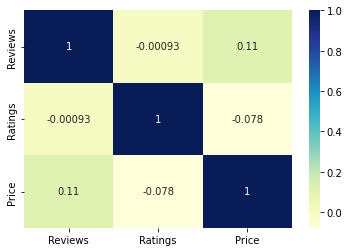

In [395]:
sns.heatmap(data.corr(), annot = True, cmap = "YlGnBu")
# plt.title("Wykres mapy ciepła zależności wart. liczbowych w zbiorze\n")

In [396]:
data['Genre'].value_counts()

Action & Adventure (Books)               1183
Romance (Books)                           517
Biographies & Autobiographies (Books)     463
Crime, Thriller & Mystery (Books)         335
Contemporary Fiction (Books)              325
                                         ... 
Bodybuilding & Weightlifting (Books)        1
Immunology                                  1
Target Shooting (Books)                     1
Ecotourism                                  1
Military History (Books)                    1
Name: Genre, Length: 363, dtype: int64

In [397]:
data['BookCategory'].value_counts()

Action & Adventure                      1036
Crime, Thriller & Mystery                878
Comics & Mangas                          744
Language, Linguistics & Writing          733
Biographies, Diaries & True Accounts     732
Romance                                  702
Humour                                   670
Computing, Internet & Digital Media      648
Arts, Film & Photography                 638
Sports                                   614
Politics                                 402
Name: BookCategory, dtype: int64

In [398]:
data = data.drop(["Genre"], axis=1)
data.head()

,Edition,Reviews,Ratings,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure,220.00,train,"(2010, 2020]"
1,Paperback,3.9,14,"Biographies, Diaries & True Accounts",202.93,train,"(2010, 2020]"
2,Paperback,4.8,6,Humour,299.00,train,"(0, 1990]"
3,Paperback,4.1,13,"Crime, Thriller & Mystery",180.00,train,"(2010, 2020]"
4,Hardcover,5.0,1,"Arts, Film & Photography",965.62,train,"(2000, 2010]"


In [399]:
# podział na zbiory testowy i treningowy
train = data[data["Type"] == 'train']
test = data[data["Type"] == 'test']

train = train.drop(['Type'], axis=1)
test = test.drop(['Type'], axis=1)

# train.to_excel("train_proccessed.xlsx")
# test.to_excel("train_proccessed.xlsx")
train.head()

,Edition,Reviews,Ratings,BookCategory,Price,Year
0,Paperback,4.0,8,Action & Adventure,220.00,"(2010, 2020]"
1,Paperback,3.9,14,"Biographies, Diaries & True Accounts",202.93,"(2010, 2020]"
2,Paperback,4.8,6,Humour,299.00,"(0, 1990]"
3,Paperback,4.1,13,"Crime, Thriller & Mystery",180.00,"(2010, 2020]"
4,Hardcover,5.0,1,"Arts, Film & Photography",965.62,"(2000, 2010]"


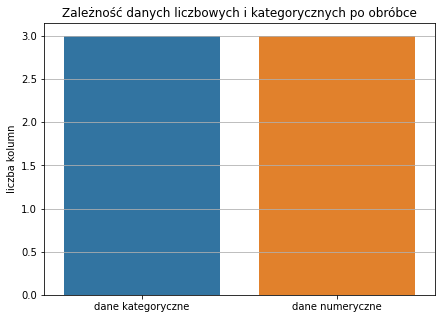

In [400]:
col_data_type = []
for col in train.columns:
    if train[col].dtype in ['int64','float64']:
        col_data_type.append('dane numeryczne')
    else:
        col_data_type.append('dane kategoryczne')


plt.figure(figsize=(7,5))
plt.grid()
sns.countplot(x=col_data_type)
plt.ylabel('liczba kolumn')
plt.title('Zależność danych liczbowych i kategorycznych po obróbce')
plt.show()

## Kodowanie i skalowanie danych

In [401]:
encode = LabelEncoder()
new_data = copy.copy(data)
new_data['Edition'] = encode.fit_transform(list(data['Edition']))
new_data['BookCategory'] = encode.fit_transform(list(data['BookCategory']))
new_data['Year'] = encode.fit_transform(list(data['Year']))
new_data.head()

,Edition,Reviews,Ratings,BookCategory,Price,Type,Year
0,4,4.0,8,0,220.00,train,3
1,4,3.9,14,2,202.93,train,3
2,4,4.8,6,6,299.00,train,0
3,4,4.1,13,5,180.00,train,3
4,1,5.0,1,1,965.62,train,2


In [402]:
# podział na zbiory testowy i treningowy
new_train = new_data[new_data["Type"] == 'train']
new_test = new_data[new_data["Type"] == 'test']

new_train = new_train.drop(['Type'], axis=1)
new_test = new_test.drop(['Type'], axis=1)

# train.to_excel("train_proccessed.xlsx")
# test.to_excel("train_proccessed.xlsx")
new_train.head()

,Edition,Reviews,Ratings,BookCategory,Price,Year
0,4,4.0,8,0,220.00,3
1,4,3.9,14,2,202.93,3
2,4,4.8,6,6,299.00,0
3,4,4.1,13,5,180.00,3
4,1,5.0,1,1,965.62,2


In [408]:
X_train = new_train.drop(['Price'],axis = 1)
y_train = new_train['Price'] #.values
X_test = new_test.drop(["Price"], axis=1)
# X_train.describe(include = 'all')

# SCALE
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# reshaping
y_train = y_train.values.reshape((len(y_train), 1))
y_train = sc.fit_transform(y_train)
y_train = y_train.ravel()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(6237, 5)
(1560, 5)
(6237,)


In [405]:
np.savetxt("X_train.txt", X_train)
np.savetxt("X_test.txt", X_test)
np.savetxt("y_train.txt", y_train)

## Testing

In [410]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.3, random_state = 123)

# make plot with different test sizes to show which is more optimal

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(4365, 5)
(4365,)
(1872, 5)
(1872,)


Training score:  0.16664951394803273
Training score:  0.29646441083680075
Training score:  0.5056313649558519
Training score:  0.647488305183586
Training score:  0.7226483284065626
Training score:  0.7427925889492563
Training score:  0.7459786055324988
Training score:  0.746023313452642
Training score:  0.7460809913170475
Training score:  0.7461090159687381
Training score:  0.7461355969048536
Training score:  0.7461374925022846
Training score:  0.7461593393352788
Training score:  0.746154974549841


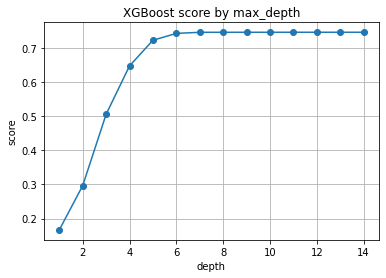

In [416]:
skorr = []

for i in range(1, 15):
    xgb=XGBRegressor(n_estimators=1000, max_depth=i)

    xgb.fit(train_x, train_y)

    y_ = xgb.predict(val_x)

    y_pred = sc.inverse_transform([y_])
    y_true = sc.inverse_transform([val_y])

    score_ = xgb.score(train_x, train_y)  
    print("Training score: ", score_)
    skorr.append(score_)

plt.plot(np.arange(1,15), skorr, '-o')
plt.title('XGBoost score by max_depth')
plt.grid()
plt.ylabel('score')
plt.xlabel('depth')
plt.show()